In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import pickle
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [2]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    data_folder = [os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    data_folders = []
    for i in range(1, len(data_folder)):
        data_folders.append(data_folder[i])
    print(data_folders)
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))

    return data_folders

train_filename = 'notMNIST_large'
test_filename = 'notMNIST_small'
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


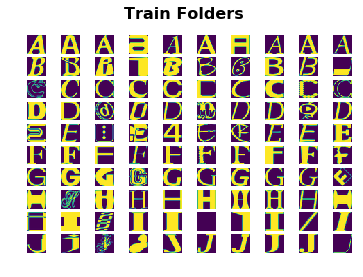

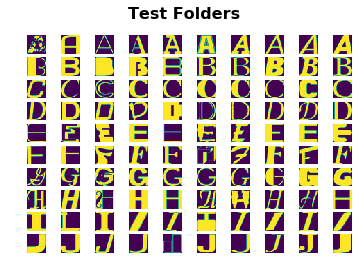

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

In [3]:
# ---
# Problem1
# ---------
#
# Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.
#
# ---

# Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.
#
# We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
#
# A few images might not be readable, we'll just skip them.
import random
import matplotlib.image as mpimg


def plot_samples(data_folders, sample_size, title=None):
    fig = plt.figure()
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    for folder in data_folders:
        image_files = os.listdir(folder)
        image_sample = random.sample(image_files, sample_size)
        for image in image_sample:
            image_file = os.path.join(folder, image)
            ax = fig.add_subplot(len(data_folders), sample_size, sample_size * data_folders.index(folder) +
                                 image_sample.index(image) + 1)
            image = mpimg.imread(image_file)
            ax.imshow(image)
            ax.set_axis_off()

    plt.show()


plot_samples(train_folders, 10, 'Train Folders')
plot_samples(test_folders, 10, 'Test Folders')

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.


def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset


def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            print(dataset)
            try:
                f = open(set_filename, 'wb')
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
                f.close()
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names


train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

['notMNIST_large/A.pickle', 'notMNIST_large/B.pickle', 'notMNIST_large/C.pickle', 'notMNIST_large/D.pickle', 'notMNIST_large/E.pickle', 'notMNIST_large/F.pickle', 'notMNIST_large/G.pickle', 'notMNIST_large/H.pickle', 'notMNIST_large/I.pickle', 'notMNIST_large/J.pickle']
notMNIST_large/A.pickle
notMNIST_large/B.pickle
notMNIST_large/C.pickle
notMNIST_large/D.pickle
notMNIST_large/E.pickle
notMNIST_large/F.pickle
notMNIST_large/G.pickle
notMNIST_large/H.pickle
notMNIST_large/I.pickle
notMNIST_large/J.pickle
['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle', 'notMNIST_small/D.pickle', 'notMNIST_small/E.pickle', 'notMNIST_small/F.pickle', 'notMNIST_small/G.pickle', 'notMNIST_small/H.pickle', 'notMNIST_small/I.pickle', 'notMNIST_small/J.pickle']
notMNIST_small/A.pickle
notMNIST_small/B.pickle
notMNIST_small/C.pickle
notMNIST_small/D.pickle
notMNIST_small/E.pickle
notMNIST_small/F.pickle
notMNIST_small/G.pickle
notMNIST_small/H.pickle
notMNIST_small/I.pickle
no

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


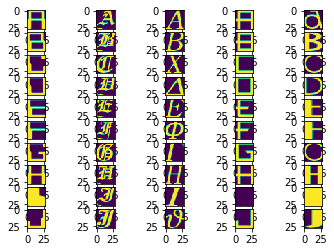

In [4]:
#Problem2 Displaying a sample of the labels and images from the ndarray

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
import matplotlib.pyplot as plt
def load_and_displayImage_from_pickle(data_filename_set, NumClass, NumImage):
    print(data_filename_set)
    if(NumImage <= 0):
        print('NumImage <= 0')
        return
    plt.figure('subplot')
    for index, pickle_file in enumerate(data_filename_set):
        print(pickle_file)
        with open(pickle_file,'rb') as f:
            data = pickle.load(f)
            ImageList = data[0:NumImage, :, :]
            for i,Image in enumerate(ImageList):
                #NumClass代表类别，每个类别一行;NumImage代表每个类显示的图像张数
                plt.subplot(NumClass, NumImage, index*NumImage+i+1)
                plt.imshow(Image)
            index = index+1       
            
#显示10类，每类显示5张图片        
load_and_displayImage_from_pickle(train_datasets, 10, 5)    
load_and_displayImage_from_pickle(test_datasets, 10, 5) 

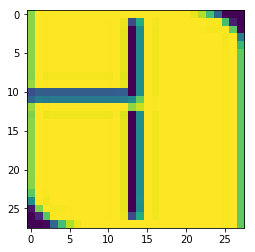

In [5]:
# index 0 should be all As, 1 = all Bs, etc.
pickle_file = train_datasets[0]  
# With would automatically close the file after the nested block of code
def load_data(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)  
    except EOFError:
        return None
    
letter_set = load_data(pickle_file)
# pick a random image index
sample_idx = np.random.randint(len(letter_set))
    
# extract a 2D slice
sample_image = letter_set[sample_idx, :, :]  
plt.figure()
    
# display it
plt.imshow(sample_image)

Total images in notMNIST_small/A.pickle : 1872
Total images in notMNIST_small/B.pickle : 1873
Total images in notMNIST_small/C.pickle : 1873
Total images in notMNIST_small/D.pickle : 1873
Total images in notMNIST_small/E.pickle : 1873
Total images in notMNIST_small/F.pickle : 1872
Total images in notMNIST_small/G.pickle : 1872
Total images in notMNIST_small/H.pickle : 1872
Total images in notMNIST_small/I.pickle : 1872
Total images in notMNIST_small/J.pickle : 1872
mean of # images : 1872.4
Well balanced 1872
Well balanced 1873
Well balanced 1873
Well balanced 1873
Well balanced 1873
Well balanced 1872
Well balanced 1872
Well balanced 1872
Well balanced 1872
Well balanced 1872


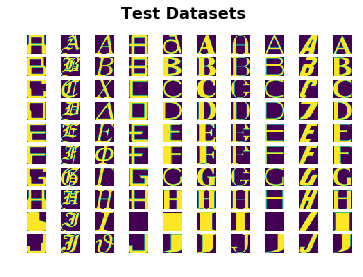

Total images in notMNIST_large/A.pickle : 52909
Total images in notMNIST_large/B.pickle : 52911
Total images in notMNIST_large/C.pickle : 52912
Total images in notMNIST_large/D.pickle : 52911
Total images in notMNIST_large/E.pickle : 52912
Total images in notMNIST_large/F.pickle : 52912
Total images in notMNIST_large/G.pickle : 52912
Total images in notMNIST_large/H.pickle : 52912
Total images in notMNIST_large/I.pickle : 52912
Total images in notMNIST_large/J.pickle : 52911
mean of # images : 52911.4
Well balanced 52909
Well balanced 52911
Well balanced 52912
Well balanced 52911
Well balanced 52912
Well balanced 52912
Well balanced 52912
Well balanced 52912
Well balanced 52912
Well balanced 52911


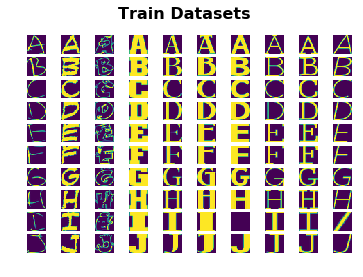

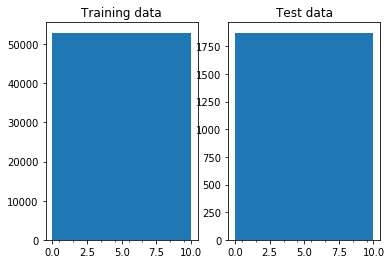

In [6]:

# ---
# Problem 2
# ---------
#
# Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.
#
# ---

# ---
# Problem 3
# ---------
# Another check: we expect the data to be balanced across classes. Verify that.
#
# ---

def generate_fake_label(sizes):
    labels = np.ndarray(sum(sizes), dtype=np.int32)
    start = 0
    end = 0
    for label, size in enumerate(sizes):
        start = end
        end += size
        for j in range(start, end):
            labels[j] = label
    return labels


def plot_balance():
    fig, ax = plt.subplots(1, 2)
    bins = np.arange(train_labels.min(), train_labels.max() + 2)
    ax[0].hist(train_labels, bins=bins)
    ax[0].set_xticks((bins[:-1] + bins[1:]) / 2, [chr(k) for k in range(ord("A"), ord("J") + 1)])
    ax[0].set_title("Training data")

    bins = np.arange(test_labels.min(), test_labels.max() + 2)
    ax[1].hist(test_labels, bins=bins)
    ax[1].set_xticks((bins[:-1] + bins[1:]) / 2, [chr(k) for k in range(ord("A"), ord("J") + 1)])
    ax[1].set_title("Test data")
    plt.show()


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def balance_check(sizes):
    mean_val = mean(sizes)
    print('mean of # images :', mean_val)
    for i in sizes:
        if abs(i - mean_val) > 0.1 * mean_val:
            print("Too much or less images")
        else:
            print("Well balanced", i)


def load_and_display_pickle(datasets, sample_size, title=None):
    fig = plt.figure()
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    num_of_images = []
    for pickle_file in datasets:
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
            # 
            print('Total images in', pickle_file, ':', len(data))

            for index, image in enumerate(data):
                if index == sample_size: break
                ax = fig.add_subplot(len(datasets), sample_size, sample_size * datasets.index(pickle_file) +
                                     index + 1)
                ax.imshow(image)
                ax.set_axis_off()
                ax.imshow(image)

            num_of_images.append(len(data))

    balance_check(num_of_images)
    plt.show()
    return num_of_images


test_labels = generate_fake_label(load_and_display_pickle(test_datasets, 10, 'Test Datasets'))
train_labels = generate_fake_label(load_and_display_pickle(train_datasets, 10, 'Train Datasets'))

plot_balance()

In [7]:
# Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.
#
# Also create a validation dataset for hyperparameter tuning.

def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels


def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
   
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels


train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
    train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Number of overlaps: 1267


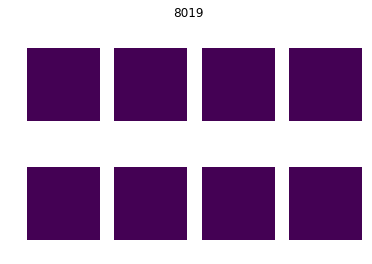

Overlapping images removed from test_dataset:  1267
Overlapping images removed from valid_dataset:  1059
Training: (200000, 28, 28) (200000,)
Validation: (8941,) (8941,)
Testing: (8733, 28, 28) (8733,)
Compressed pickle size: 683496866


In [8]:
# ---
# Problem 5
# ---------
#
# By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
# Measure how much overlap there is between training, validation and test samples.
#
# Optional questions:
# - What about near duplicates between datasets? (images that are almost identical)
# - Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
# ---

# Reference：https://github.com/Arn-O/udacity-deep-learning/blob/master/1_notmnist.ipynb
import hashlib


def extract_overlap_hash_where(dataset_1, dataset_2):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap


def display_overlap(overlap, source_dataset, target_dataset):
    overlap = {k: v for k, v in overlap.items() if len(v) >= 3}
    item = random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i + 1)
        plt.axis('off')
        plt.imshow(img)

    plt.show()


def sanitize(dataset_1, dataset_2, labels_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = []  # list of indexes
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)


overlap_test_train = extract_overlap_hash_where(test_dataset, train_dataset)
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset, train_dataset)

test_dataset_sanit, test_labels_sanit = sanitize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed from test_dataset: ', len(test_dataset) - len(test_dataset_sanit))
valid_dataset_sanit, valid_labels_sanit = sanitize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed from valid_dataset: ', len(valid_dataset) - len(valid_dataset_sanit))
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_labels_sanit.shape, valid_labels_sanit.shape)
print('Testing:', test_dataset_sanit.shape, test_labels_sanit.shape)
pickle_file_sanit = 'notMNIST_sanit.pickle'

try:
    f = open(pickle_file_sanit, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset_sanit,
        'valid_labels': valid_labels_sanit,
        'test_dataset': test_dataset_sanit,
        'test_labels': test_labels_sanit,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

Using TensorFlow backend.


In [73]:
img_rows, img_cols, img_depth = 28, 28, 1


In [74]:
def count_label(label):
    label = list(label)
    a = []
    a.append(label.count(0))
    for i in range(1, 10):
        a.append(label.count(i))
    return a


In [75]:
train_label_count = count_label(train_labels)
valid_label_count = count_label(valid_labels_sanit)
test_label_count = count_label(test_labels_sanit)

In [76]:
print(test_label_count)

[883, 904, 877, 886, 895, 894, 893, 871, 757, 873]


In [77]:
def label_value(label_count, frames):
    b = []
    label = []
    b.append(int(label_count[0]/frames))
    for h in range(0, b[0]):
        label.append(0)   
    start = b[0]    
    for i in range(1, 10):
        b.append(int(label_count[i]/frames))
        start += b[i-1]
        end = start + b[i]
        for j in range(start, end):
            label.append(i)
    return label, b

In [78]:
train_label3, train_b = label_value(train_label_count, img_depth)
test_label3, test_b = label_value(test_label_count, img_depth)
valid_label3, valid_b = label_value(valid_label_count, img_depth)

In [85]:
print(sum(train_b), train_b)
print(sum(valid_b), valid_b)
print(sum(test_b), test_b)

200000 [20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000]
8941 [910, 910, 901, 906, 913, 918, 892, 908, 799, 884]
8733 [883, 904, 877, 886, 895, 894, 893, 871, 757, 873]


In [89]:
# 对图片进行预处理，将其整合为适合输入到3D模型中的5D张量
def three2five(dataset, frames, b):
    img_num = dataset.shape[0]
    cube_num = b
    b_sum = sum(b)
    
    img = dataset[0]
    img_0 = img.reshape(1, img.shape[0], img.shape[1], 1)
    img_frames = img_0
    
    for i in range(1, frames):
        img = dataset[i]
        img_0 = img.reshape(1, img.shape[0], img.shape[1], 1)
        img_frames = np.concatenate((img_frames, img_0), axis=0)
    cube = img_frames.reshape(1, img_frames.shape[0], img_frames.shape[1], img_frames.shape[2], img_frames.shape[3])
    
    for i in range(1, cube_num[0]):
        index = frames*i
        img = dataset[index]
        img_0 = img.reshape(1, img.shape[0], img.shape[1], 1)
        img_frames = img_0
        
        for j in range(1, frames):
            img = dataset[index+j]
            img_0 = img.reshape(1, img.shape[0], img.shape[1], 1)
            img_frames = np.concatenate((img_frames, img_0), axis=0)
        
        img_frames = img_frames.reshape(1, img_frames.shape[0], img_frames.shape[1], img_frames.shape[2], img_frames.shape[3])
        cube = np.concatenate((cube, img_frames), axis=0)
    cube_sum = cube
    
    for h in range(1, len(cube_num)):
        img = dataset[i]
        img_0 = img.reshape(1, img.shape[0], img.shape[1], 1)
        img_frames = img_0
    
        for i in range(1, frames):
            img = dataset[i]
            img_0 = img.reshape(1, img.shape[0], img.shape[1], 1)
            img_frames = np.concatenate((img_frames, img_0), axis=0)
        cube = img_frames.reshape(1, img_frames.shape[0], img_frames.shape[1], img_frames.shape[2], img_frames.shape[3])
    
        for i in range(1, cube_num[h]):
            index = frames*i
            img = dataset[index]
            img_0 = img.reshape(1, img.shape[0], img.shape[1], 1)
            img_frames = img_0
        
            for j in range(1, frames):
                img = dataset[index+j]
                img_0 = img.reshape(1, img.shape[0], img.shape[1], 1)
                img_frames = np.concatenate((img_frames, img_0), axis=0)
        
            img_frames = img_frames.reshape(1, img_frames.shape[0], img_frames.shape[1], img_frames.shape[2], img_frames.shape[3])
            cube = np.concatenate((cube, img_frames), axis=0)
        cube_sum = np.concatenate((cube_sum, cube), axis=0)  
        print(cube_sum.shape)
    return cube_sum

In [87]:
X_tr = train_dataset

In [91]:
# dataset
X_tr_cube = three2five(X_tr, img_depth, train_b)
print("X_tr_cube's shape = ", X_tr_cube.shape)

(40000, 1, 28, 28, 1)
(60000, 1, 28, 28, 1)
(80000, 1, 28, 28, 1)
(100000, 1, 28, 28, 1)
(120000, 1, 28, 28, 1)
(140000, 1, 28, 28, 1)
(160000, 1, 28, 28, 1)
(180000, 1, 28, 28, 1)
(200000, 1, 28, 28, 1)
X_tr_cube's shape =  (200000, 1, 28, 28, 1)


In [92]:
train_set = X_tr_cube

In [93]:
valid_dataset_sanit_cube = three2five(valid_dataset_sanit, img_depth, valid_b)
print("valid_dataset_sanit's shape = ", valid_dataset_sanit_cube.shape)
test_dataset_sanit_cube = three2five(test_dataset_sanit, img_depth, test_b)
print("test_dataset's shape = ", test_dataset_sanit_cube.shape)

(1820, 1, 28, 28, 1)
(2721, 1, 28, 28, 1)
(3627, 1, 28, 28, 1)
(4540, 1, 28, 28, 1)
(5458, 1, 28, 28, 1)
(6350, 1, 28, 28, 1)
(7258, 1, 28, 28, 1)
(8057, 1, 28, 28, 1)
(8941, 1, 28, 28, 1)
valid_dataset_sanit's shape =  (8941, 1, 28, 28, 1)
(1787, 1, 28, 28, 1)
(2664, 1, 28, 28, 1)
(3550, 1, 28, 28, 1)
(4445, 1, 28, 28, 1)
(5339, 1, 28, 28, 1)
(6232, 1, 28, 28, 1)
(7103, 1, 28, 28, 1)
(7860, 1, 28, 28, 1)
(8733, 1, 28, 28, 1)
test_dataset's shape =  (8733, 1, 28, 28, 1)


In [94]:
test_set = test_dataset_sanit_cube
valid_set = valid_dataset_sanit_cube

In [95]:
# 3D CNN模型
#reshaping    
X_train = train_set
X_test = test_set
input_shape = (img_depth, img_cols, img_rows, 1)
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train -= np.mean(X_train)
X_train /= np.max(X_train)

num_category = 10
n_filters = 32
#convert class vectors to binary class matrices
y_train = train_label3
y_test = test_label3
    
y_train = keras.utils.to_categorical(train_label3, num_category)
y_test = keras.utils.to_categorical(test_label3, num_category)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(y_test[0])

(200000, 1, 28, 28, 1) (200000, 10)
(8733, 1, 28, 28, 1) (8733, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [97]:
model = Sequential()
model.add(Convolution3D(n_filters, 
                            kernel_size=(1, 3, 3),
                            input_shape=input_shape,
                            activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, init='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_category, init='normal', activation='softmax'))
    
model.summary()
    
# 保存模型的权重
# checkpoint best neural network model only
filepath = "3DCNN.notMNIST.weight.best.hdf5"

# checkpoint
checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')
    
model.compile(loss=keras.losses.categorical_crossentropy,
                         optimizer=keras.optimizers.Adadelta(),
                         metrics=['mse', 'accuracy'])

batch_size = 128
num_epoch = 50

model_log = model.fit(X_train, y_train, 
                                batch_size=batch_size,
                                epochs=num_epoch,
                                verbose=1,
                                validation_data=(X_test, y_test), 
                                shuffle=True,
                                callbacks=[checkpoint])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="normal")`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 1, 26, 26, 32)     320       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 1, 13, 13, 32)     0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 13, 13, 32)     0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               692352    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total para

KeyboardInterrupt: 

In [ ]:
pred_labels = model.predict(X_test)
print(pred_labels[0])

In [ ]:
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
plt.show()